In [1]:
import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.ml import get_device, TexCoordsRegressionModel
from keyrover import *

2024-11-18 19:56:52.600 Python[1943:38695] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [2]:
device = get_device()
device

'mps'

In [3]:
image_paths = get_dataset_paths()
len(image_paths)

4999

In [4]:
mean, std = get_dataset_norm_params(version=3)
mean, std

(array([    0.26772,     0.28418,     0.28728]),
 array([    0.24712,      0.2489,     0.25881]))

In [5]:
train_paths, _, valid_paths = split_train_test_valid(image_paths, 1, 0.1)

SIZE = (256, 256)

train_dataset = KeyboardTexCoordsDataset(train_paths, size=SIZE)
valid_dataset = KeyboardTexCoordsDataset(valid_paths, size=SIZE)

len(train_dataset), len(valid_dataset)

  0%|          | 0/4500 [00:00<?, ?it/s]

2024-11-18 19:56:58.677 Python[1964:38833] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:56:58.845 Python[1962:38828] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:56:58.879 Python[1957:38811] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:56:59.102 Python[1956:38805] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:56:59.102 Python[1965:38839] WARNING: Secure coding is not enabled for restorable state! Enabl

  0%|          | 0/499 [00:00<?, ?it/s]

2024-11-18 19:57:14.051 Python[2019:39397] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:14.237 Python[2023:39408] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:14.238 Python[2018:39393] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:14.334 Python[2024:39413] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:14.450 Python[2022:39406] WARNING: Secure coding is not enabled for restorable state! Enabl

(4500, 499)

In [6]:
# train_dataset.set_transforms([
    #     # transforms.RandomHorizontalFlip(p=0.5),
    #     # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    #     # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    #     # transforms.RandomErasing(p=0.5),
# ])

train_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

Mask tensor(-1.) tensor(0.9141) torch.float32 torch.Size([2, 256, 256])
Image tensor(-1.1417) tensor(2.8940)


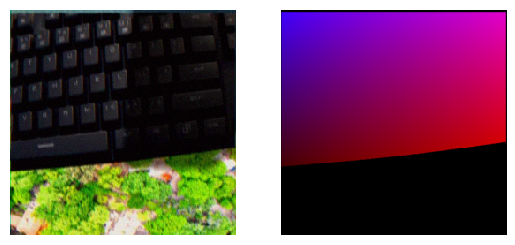

In [7]:
img, mask = train_dataset.random_img()
print("Mask", mask.min(), mask.max(), mask.dtype, mask.shape)
print("Image", img.min(), img.max())
imshow(img, mask)

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 48

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": False}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)

In [9]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [10]:
ARCH = "unet"
BACKBONE = "timm-regnetx_004"

LEARNING_RATE = 2e-3

wandb.finish()
model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, encoder_weights="imagenet",
                                 lr=LEARNING_RATE, activation="tanh")
model

TexCoordsRegressionModel(
  (model): Unet(
    (encoder): RegNetEncoder(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (s1): RegStage(
        (b1): Bottleneck(
          (conv1): ConvNormAct(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_runni

In [11]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Unet    | 7.3 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.228    Total estimated model params size (MB)
542       Modules in train mode
0         Modules in eval mode

In [12]:
logger = WandbLogger(project="mrover-keyboard-texcoords-segmentation")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Unet    | 7.3 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.228    Total estimated model params size (MB)
542       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2024-11-18 19:57:21.055 Python[2092:40044] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:21.055 Python[2093:40047] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:25.463 Python[2100:40175] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-18 19:57:29.378 Python[2104:40288] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [46]:
torch.save(model.state_dict(), f"models/texcoords/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")

tensor(-1.1417) tensor(2.9633)


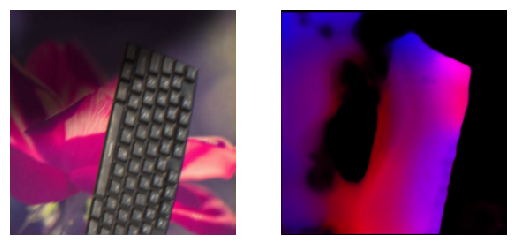

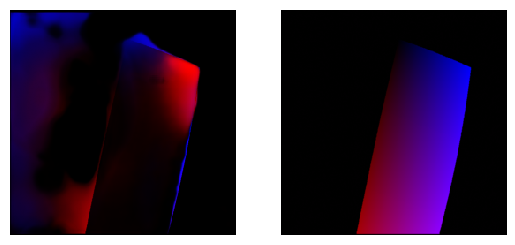

In [35]:
img, mask = valid_dataset.random_img()
pred = model.predict(img)

print(img.min(), img.max())

imshow(img, pred)
imshow((mask - pred) ** 2, mask)
# imshow(pred > 1)

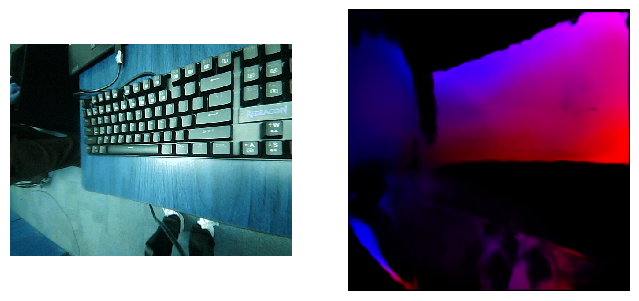

In [61]:
img = cv2.imread(f"datasets/test/7.jpg")

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

pred = model.predict(transform(img))
imshow(img, pred, figsize=(8, 8))

In [ ]:
pred.shape